<a href="https://colab.research.google.com/github/ayman86/Photo_Quality_Classification/blob/main/InceptionResNet_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import os
import random
import matplotlib.pylab as plt
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

In [3]:
def proc_image_dir(Images_Path):
    
    image_classes = sorted([dirname for dirname in os.listdir(Images_Path)
                      if os.path.isdir(os.path.join(Images_Path, dirname))])
    # and not dirname.startswith(".") and not dirname.startswith("mblur")])
    #image_classes.append('mblur')
    
    print(image_classes)
    
    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
    WIDTH = 256
    HEIGHT = 256
  
    print("Adding Images: ",end="")
    i = 0
    for image_class in image_classes:
        print("Processing ", image_class)
        items = glob(os.path.join(Images_Path, image_class,"*"))
        for item in items:
            if item.lower().endswith(".jpg") or item.lower().endswith(".bmp"):
                # Read and resize image
                full_size_image = cv2.imread(item)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                out = [0] * len(image_classes)
                out[i] = 1
                y.append(out)
        i+=1

    print("")
    return x,y,image_classes

def horizontal_motion_blur(img, blur_factor):
    import cv2 
    import numpy as np 

    kernel_size = blur_factor
    kernel_h = np.zeros((kernel_size, kernel_size))
    kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size) 
    kernel_h /= kernel_size 

    # Apply the horizontal kernel. 
    horizontal_mb = cv2.filter2D(img, -1, kernel_h) 
    
    return horizontal_mb

In [4]:
PATH = os.path.abspath(os.path.join('.', 'databaserelease2'))

# ./input/sample/images/
SOURCE_IMAGES = '/content/drive/MyDrive/Datasets - Copy/First Dataset'#os.path.join(PATH, "sample", "images")
x2,y2,image_classes = proc_image_dir(SOURCE_IMAGES)


['bad_lighting', 'fastfading', 'gblur', 'jp2k', 'jpeg', 'refimgs']
Adding Images: Processing  bad_lighting
Processing  fastfading
Processing  gblur
Processing  jp2k
Processing  jpeg
Processing  refimgs



In [5]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x2,y2, test_size=0.20, random_state=1, stratify=y2)

# Second split the 40% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

print(np.array(X_train).shape)
print(np.array(X_val).shape)
print(np.array(X_test).shape)

(796, 256, 256, 3)
(100, 256, 256, 3)
(100, 256, 256, 3)


In [6]:
num_classes=6

K.image_data_format()

img_width, img_height = 256, 256
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 100
batch_size = 16

In [7]:
input_shape = (256,256,3)

model=Sequential()
model.add(InceptionResNetV2(include_top=False,pooling='avg',weights='imagenet'))
model.add(Dense(num_classes,activation='softmax'))

model.summary()



219070464/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 9222      
                                                                 
Total params: 54,345,958
Trainable params: 54,285,414
Non-trainable params: 60,544
_________________________________________________________________


In [8]:
from tensorflow.keras import layers, models, optimizers
model.compile(
	loss='binary_crossentropy',
	optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
	metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='reflect')
valtest_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size)

history = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), epochs=50)


Epoch 1/50
25/25 [==============================] - 55s 992ms/step - loss: 0.4315 - acc: 0.3731 - val_loss: 1077339.5000 - val_acc: 0.2300
Epoch 2/50
25/25 [==============================] - 18s 704ms/step - loss: 0.2977 - acc: 0.5364 - val_loss: 1681.6904 - val_acc: 0.2100
Epoch 3/50
25/25 [==============================] - 18s 713ms/step - loss: 0.2690 - acc: 0.5905 - val_loss: 13.8604 - val_acc: 0.2600
Epoch 4/50
25/25 [==============================] - 19s 746ms/step - loss: 0.2500 - acc: 0.6168 - val_loss: 1.9344 - val_acc: 0.3000
Epoch 5/50
25/25 [==============================] - 18s 727ms/step - loss: 0.2326 - acc: 0.6533 - val_loss: 0.6305 - val_acc: 0.4400
Epoch 6/50
25/25 [==============================] - 19s 759ms/step - loss: 0.2136 - acc: 0.6759 - val_loss: 1.0125 - val_acc: 0.2300
Epoch 7/50
25/25 [==============================] - 18s 735ms/step - loss: 0.2226 - acc: 0.6482 - val_loss: 0.2915 - val_acc: 0.5800
Epoch 8/50
25/25 [==============================] - 19s 766

In [10]:
model.save_weights('/content/drive/MyDrive/Datasets - Copy/8020weights.h5')


In [11]:
model.load_weights('/content/drive/MyDrive/Datasets - Copy/8020weights.h5')


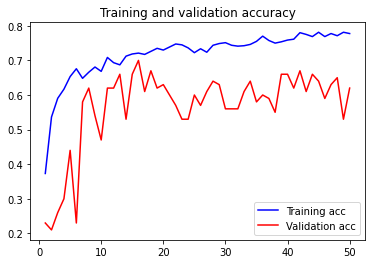

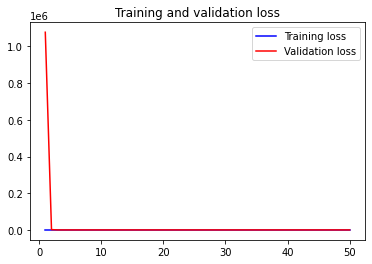

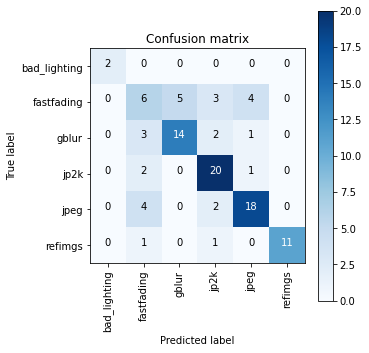

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("/content/drive/MyDrive/Datasets - Copy/trvlAcc.png")
plt.show()

plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Datasets - Copy/trvlLoss.png")
plt.show()

import sklearn
import itertools
from sklearn.metrics import confusion_matrix
dict_characters = {0: 'Clear', 1: 'Blurry'}
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("/content/drive/MyDrive/Datasets - Copy/cm-"+title+".png")
    plt.show()

    
a=np.array(X_test)
b=np.array(y_test)
Y_pred = model.predict(a)


Y_pred_classes = np.argmax(Y_pred,axis=1)
confusion_mtx = confusion_matrix(np.argmax(b,axis=1), Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(image_classes))

In [13]:
sklearn.metrics.accuracy_score(Y_pred_classes,np.argmax(b,axis=1))


0.71

In [14]:
confusion_mtx


array([[ 2,  0,  0,  0,  0,  0],
       [ 0,  6,  5,  3,  4,  0],
       [ 0,  3, 14,  2,  1,  0],
       [ 0,  2,  0, 20,  1,  0],
       [ 0,  4,  0,  2, 18,  0],
       [ 0,  1,  0,  1,  0, 11]])

In [15]:
class_totals = [sum(i) for i in confusion_mtx]
class_totals

[2, 18, 20, 23, 24, 13]

In [16]:
class_correct_pred = [confusion_mtx[i][i] for i in range(6)]
class_correct_pred

[2, 6, 14, 20, 18, 11]

In [17]:
accuracies = [class_correct_pred[i]/class_totals[i] for i in range(6)]
accuracies

[1.0, 0.3333333333333333, 0.7, 0.8695652173913043, 0.75, 0.8461538461538461]

In [18]:
class_totals = [sum(i) for i in confusion_mtx]
class_totals

tp = [confusion_mtx[i][i] for i in range(6)]
tp

sensetivity = [tp[i]/class_totals[i] for i in range(6)]
sensetivity

[1.0, 0.3333333333333333, 0.7, 0.8695652173913043, 0.75, 0.8461538461538461]

In [19]:
fp = [[sum(x) for x in zip(*confusion_mtx)][i] - tp[i] for i in range(6)]
fp

[0, 10, 5, 8, 6, 0]

In [20]:
sumall = sum(map(sum, confusion_mtx))
print(sumall)
tn = [sumall - [sum(x) for x in zip(*confusion_mtx)][i] for i in range(6)]
tn
specificity = [tn[i]/(tn[i]+fp[i]) for i in range(6)]
specificity

100


[1.0, 0.8936170212765957, 0.9418604651162791, 0.9, 0.926829268292683, 1.0]

In [21]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.01,
                                   zoom_range=[0.9, 1.25],
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode='reflect')
valtest_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size)

history = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), epochs=250)


Epoch 1/250
25/25 [==============================] - 19s 750ms/step - loss: 0.1392 - acc: 0.7864 - val_loss: 0.6710 - val_acc: 0.6000
Epoch 2/250
25/25 [==============================] - 19s 777ms/step - loss: 0.1376 - acc: 0.7789 - val_loss: 0.3431 - val_acc: 0.6300
Epoch 3/250
25/25 [==============================] - 19s 776ms/step - loss: 0.1420 - acc: 0.7688 - val_loss: 0.2982 - val_acc: 0.6200
Epoch 4/250
25/25 [==============================] - 19s 754ms/step - loss: 0.1304 - acc: 0.7864 - val_loss: 0.3750 - val_acc: 0.5900
Epoch 5/250
25/25 [==============================] - 19s 780ms/step - loss: 0.1293 - acc: 0.7802 - val_loss: 0.3499 - val_acc: 0.6100
Epoch 6/250
25/25 [==============================] - 19s 781ms/step - loss: 0.1317 - acc: 0.7877 - val_loss: 0.4932 - val_acc: 0.6600
Epoch 7/250
25/25 [==============================] - 20s 784ms/step - loss: 0.1324 - acc: 0.7852 - val_loss: 0.4324 - val_acc: 0.5700
Epoch 8/250
25/25 [==============================] - 19s 757ms

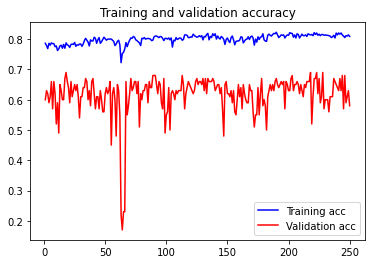

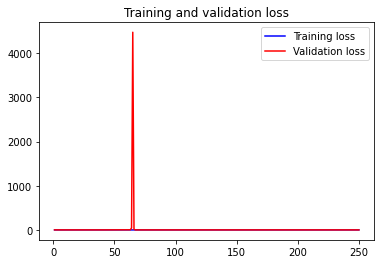

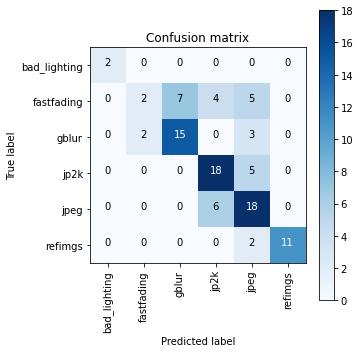

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("/content/drive/MyDrive/Datasets - Copy/trvlAcc1.png")
plt.show()

plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Datasets - Copy/trvlLoss1.png")
plt.show()

import sklearn
import itertools
from sklearn.metrics import confusion_matrix
dict_characters = {0: 'Clear', 1: 'Blurry'}
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("/content/drive/MyDrive/Datasets - Copy/cm-"+title+".png")
    plt.show()

    
a=np.array(X_test)
b=np.array(y_test)
Y_pred = model.predict(a)


Y_pred_classes = np.argmax(Y_pred,axis=1)
confusion_mtx = confusion_matrix(np.argmax(b,axis=1), Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(image_classes))

In [23]:
sklearn.metrics.accuracy_score(Y_pred_classes,np.argmax(b,axis=1))


0.66

In [24]:
confusion_mtx


array([[ 2,  0,  0,  0,  0,  0],
       [ 0,  2,  7,  4,  5,  0],
       [ 0,  2, 15,  0,  3,  0],
       [ 0,  0,  0, 18,  5,  0],
       [ 0,  0,  0,  6, 18,  0],
       [ 0,  0,  0,  0,  2, 11]])

In [25]:
accuracies = [class_correct_pred[i]/class_totals[i] for i in range(6)]
accuracies

[1.0, 0.3333333333333333, 0.7, 0.8695652173913043, 0.75, 0.8461538461538461]

In [26]:
sumall = sum(map(sum, confusion_mtx))
print(sumall)
tn = [sumall - [sum(x) for x in zip(*confusion_mtx)][i] for i in range(6)]
tn
specificity = [tn[i]/(tn[i]+fp[i]) for i in range(6)]
specificity

100


[1.0, 0.9056603773584906, 0.9397590361445783, 0.9, 0.9178082191780822, 1.0]